In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from opencc import OpenCC
import jieba
import random

# 读取数据

In [2]:
data = pd.read_csv('D:/senior/aiCourse/dataSource/comment_classification/train/sentiment_analysis_trainingset.csv',encoding='UTF-8')

In [3]:
data.columns

Index(['id', 'content', 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again'],
      dtype='object')

In [4]:
#填充空白格
data['content'] = data['content'].fillna('')

In [5]:
sample = 5000
random_indices = np.random.choice(np.arange(len(data['content'])), sample)
sub_data = data.iloc[random_indices]

In [6]:
sub_data.head()

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
12803,12803,"""环境非常好，交通便利。本来以为要找一下，没想到在凉粉桥公交站旁边就是。店外的招牌就显得相当...",1,-2,1,-2,1,-2,-2,-1,...,1,1,0,1,-2,1,-2,1,1,1
81145,81145,"""【位置交通】\n\n在西单商圈，僻静的胡同里面，第一次去，真的是百度都没有找到，附近交通便...",1,1,-1,0,-2,-2,-2,1,...,0,-1,-1,-2,0,0,1,-2,1,-2
101979,101979,"""刚从香港回来，又开始心心念念想吃港式了，朋友在美罗城附近上班，说楼上新开了一家港式，而且2...",-2,1,-2,-2,-2,-2,-2,-2,...,-2,-2,-2,-2,1,1,1,1,1,1
74614,74614,"""多谢大众点评霸王餐给我100大洋代金券，于是我又能愉快的用餐了。店铺很好找，客村地铁d出口...",1,1,1,-2,-2,-2,-2,-1,...,1,-2,-2,-2,-2,0,-2,-2,-1,-1
90448,90448,"""本来上来是要给五星的，因为觉得蛋糕便宜，味道不错，不过看到有团购自动扣掉一星，买单时看到有...",-2,-2,-2,-2,0,-2,-2,-2,...,-2,-2,-2,-2,-2,1,-2,-2,1,-2


# 预处理，主要处理content字段

In [7]:

def is_CN_char(ch):
    return ch >= u'\u4e00' and ch <= u'\u9fa5'

def cut(string):
    return list(jieba.cut(string))

def get_stopwords(filename = "D:/senior/aiCourse/dataSource/stop_word.txt"):
    stopwords_dic = open(filename, encoding= 'utf-8')
    stopwords = stopwords_dic.readlines()
    stopwords = [w.strip() for w in stopwords]
    stopwords_dic.close()
    return stopwords

def convert2simple(word):
    openCC = OpenCC('tw2sp')
    return openCC.convert(word)

In [8]:
stopwords = get_stopwords()

In [9]:
def clean_sentence(sentence):
    stopwords = get_stopwords()
    sentence = ''.join(filter(is_CN_char,sentence))
    #sentence = convert2simple(sentence)
    words = [w for w in cut(sentence) if len(w)>1 and w not in stopwords]
    words = ' '.join(words)
    return words  

In [10]:
sub_data['content'] = sub_data['content'].apply(clean_sentence)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Andywong\AppData\Local\Temp\jieba.cache
Loading model cost 1.390 seconds.
Prefix dict has been built succesfully.
e:\anaconda\envs\aicourse\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
sub_data['content'][:10]

12803     环境 交通 便利 本来 没想到 凉粉 公交站 旁边 店外 招牌 显得 档次 装修 风格 暗色...
81145     位置 交通 西单 商圈 僻静 胡同 第一次 真的 百度 找到 交通 便利 西单 地铁站 号线...
101979    香港 回来 心心念念 港式 朋友 美罗城 上班 楼上 新开 一家 港式 五折 活动 尝尝鲜 ...
74614     多谢 大众 点评 霸王餐 大洋 代金券 愉快 用餐 店铺 好找 客村 地铁 出口 星光 城入...
90448     本来 五星 蛋糕 便宜 味道 不错 团购 自动 扣掉 一星 买单 有人 手机 扫一扫 店员 ...
60636     周六 计划 朋友 逛下 头天 晚上 策划 第二天 解决 吃饭问题 计划 翠华 点评 这家 烤...
99272     晚上 七点 太兴 餐厅 正对面 柱子 贴着 一张 芒果 松饼 甜点 图片 深深 吸引 今晚 ...
87311     朋友 相约 日料 点评 随便 翻翻 这家 恒隆 交通 环境 不差 评论 欧凯 就定 这家 周...
52317     朋友 聚餐 地理位置 丰利 商场 往东 路南 好找 门口 有个 瓦罐 听说 江西 里边 不算...
45951     油饼 妈妈 重庆 火锅 位置 桂林 孩子 迷路 凭着 多方 支援 加上 百度 阿姨 成功 着...
Name: content, dtype: object

In [12]:
def word_to_id(vocab):
    counts = Counter(vocab)
    vocab = sorted(counts, key=counts.get, reverse=True)
    word_to_id = { word : i for i, word in enumerate(vocab)}
    id_to_word = {i:word for i,word in enumerate(vocab)}
    return word_to_id, id_to_word

In [13]:
vocab = ' '.join(sub_data['content']).split()
vocab.append('unknown')
word_to_id, id_to_word = word_to_id(vocab)

In [14]:
def comment_to_id(word_to_id,comments):
    comment_to_id = []
    for comment in comments:
        comment_to_id.append([word_to_id[word] for word in comment.split()] )
    return comment_to_id

In [15]:
comment_to_id = comment_to_id(word_to_id,sub_data['content'])

In [16]:
def pad_sequences(comment_to_id,maxlen,padding='post',truncating='post'):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

In [17]:
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [18]:
pad_comments.shape

(5000, 200)

In [19]:
data.columns

Index(['id', 'content', 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again'],
      dtype='object')

In [20]:
labels = sub_data[[ 'location_traffic_convenience',
       'location_distance_from_business_district', 'location_easy_to_find',
       'service_wait_time', 'service_waiters_attitude',
       'service_parking_convenience', 'service_serving_speed', 'price_level',
       'price_cost_effective', 'price_discount', 'environment_decoration',
       'environment_noise', 'environment_space', 'environment_cleaness',
       'dish_portion', 'dish_taste', 'dish_look', 'dish_recommendation',
       'others_overall_experience', 'others_willing_to_consume_again']].values

In [21]:
for i in range(len(labels)):
    for j in range(20):
        labels[i][j]+=2

In [22]:
labels[:10]

array([[3, 0, 3, 0, 3, 0, 0, 1, 0, 0, 3, 3, 2, 3, 0, 3, 0, 3, 3, 3],
       [3, 3, 1, 2, 0, 0, 0, 3, 0, 0, 2, 1, 1, 0, 2, 2, 3, 0, 3, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 0, 0, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 2, 0, 0, 1, 1],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0],
       [0, 2, 0, 0, 2, 0, 3, 3, 3, 2, 3, 3, 2, 3, 0, 3, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0],
       [3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 3, 3, 3, 3, 0, 2, 0, 0, 2, 1],
       [0, 3, 3, 0, 1, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 3, 0, 3, 3, 0],
       [0, 0, 0, 0, 3, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0]],
      dtype=int64)

In [23]:
def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [24]:
import random
x_train,y_train,x_test,y_test = split_dataset(pad_comments,labels,0.8)

# Model

In [100]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.merge import add
from keras.layers import LSTM,Bidirectional, Dropout,GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import regularizers

In [101]:
max_comment_length = 200
embedding_vecor_length = 300

In [102]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

In [107]:
model = Sequential()
model.add(Embedding(len(word_to_id), embedding_vecor_length, input_length=max_comment_length, dropout=0.2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(20, activation='sigmoid', activity_regularizer=regularizers.l2(0.001)))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=5,verbose=1, batch_size=300)

e:\anaconda\envs\aicourse\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 300)          13079700  
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 100, 100)          33200     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 20)                8880      
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                420       
Total para

In [108]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


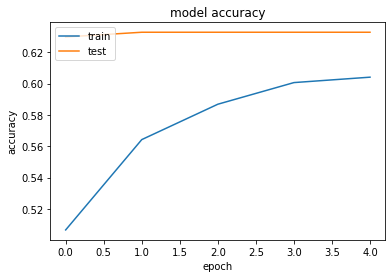

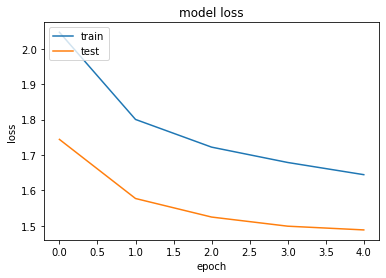

4.9


In [109]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_test)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_test))